# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [10]:
# If this cell does not work try running `pip install nbformat`

import io
# from IPython 
import nbformat

nb = nbformat.read("Lab1.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 667


## Group Number : 1

## Student 1 
### Name : Amar Mesic
### ID : 5106117

## Student 2
### Name : Athanasios Georgoutsos
### ID : 6015883

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [2]:
# Libraries used in this lab assignment

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import re

### Implementing SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# NOTE: The following code defines the paths of the data files
# Modify with your own paths OR
# create a directory with the name "cda-lab-1-credit-card-fraud" in the same directory 
# as this .ipynb file and place the data files in it

train_path = 'cda-lab-1-credit-card-fraud/train_data.csv'
test_path = 'cda-lab-1-credit-card-fraud/test_data.csv'

## 1. Visualization task – 1 A4

### Basic Preprocessing

In [4]:
# Train data loading
df = pd.read_csv(train_path)
df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


In [5]:
# Prepare card id and ip id for plotting
# Preprocessing pipeline adjusted from W1_Visuals.ipynb

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df['card_id'])
df['card_id'] = card_enc.transform(df.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df['ip_id'])
df['ip_id'] = ip_enc.transform(df.ip_id)

#Encoding, Cleaning the data
df.loc[df['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df.loc[df['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df.loc[df['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df['issuercountrycode'].unique()
unique_shopper_cc = df['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df['issuercountrycode'] = enc.transform(df.issuercountrycode)
df['shoppercountrycode'] = enc.transform(df.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df['txvariantcode'])
df['txvariantcode'] = enc1.transform(df.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df['currencycode'])
df['currencycode'] = enc2.transform(df.currencycode)

enc3 = LabelEncoder()
enc3.fit(df['shopperinteraction'])
df['shopperinteraction'] = enc3.transform(df.shopperinteraction)

df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account','',x))
df['accountcode_cc'] = 0
df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df.loc[(df['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df.loc[(df['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df.loc[(df['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df['accountcode'])
df['accountcode'] = enc4.transform(df.accountcode)

### Better to use one-hot encoding, very few categories
enc5 = LabelEncoder()
enc5.fit(df['cardverificationcodesupplied'])
df['cardverificationcodesupplied'] = enc5.transform(df.cardverificationcodesupplied)

df.loc[df['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df['mail_id'])
df['mail_id'] = enc6.transform(df.mail_id)

df.loc[df['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
df.loc[df['countries_equal'] == False,'countries_equal'] = 0
df.loc[df['countries_equal'] == True,'countries_equal'] = 1

C:\Users\Thanos\AppData\Local\Temp\ipykernel_14760\929892654.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'GB' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
C:\Users\Thanos\AppData\Local\Temp\ipykernel_14760\929892654.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['countries_equal'] == False,'countries_equal'] = 0


In [6]:
# Print columns
print('df columns: ', df.columns)

fraudulent_df = df.query('label==1')
normal_df = df[df['label'] == 0]

# Print number of records for each class and in total
print('Fraudulent transactions: ', fraudulent_df.shape[0])
print('Normal transactions: ', normal_df.shape[0])
print('all transactions: ', df.shape[0])

df columns:  Index(['Id', 'issuercountrycode', 'txvariantcode', 'bin', 'amount',
       'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
       'mail_id', 'ip_id', 'card_id', 'label', 'amount_eur', 'accountcode_cc',
       'countries_equal'],
      dtype='object')
Fraudulent transactions:  276
Normal transactions:  189352
all transactions:  189628


In [7]:
# Check Dataframe after preprocessing
df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1


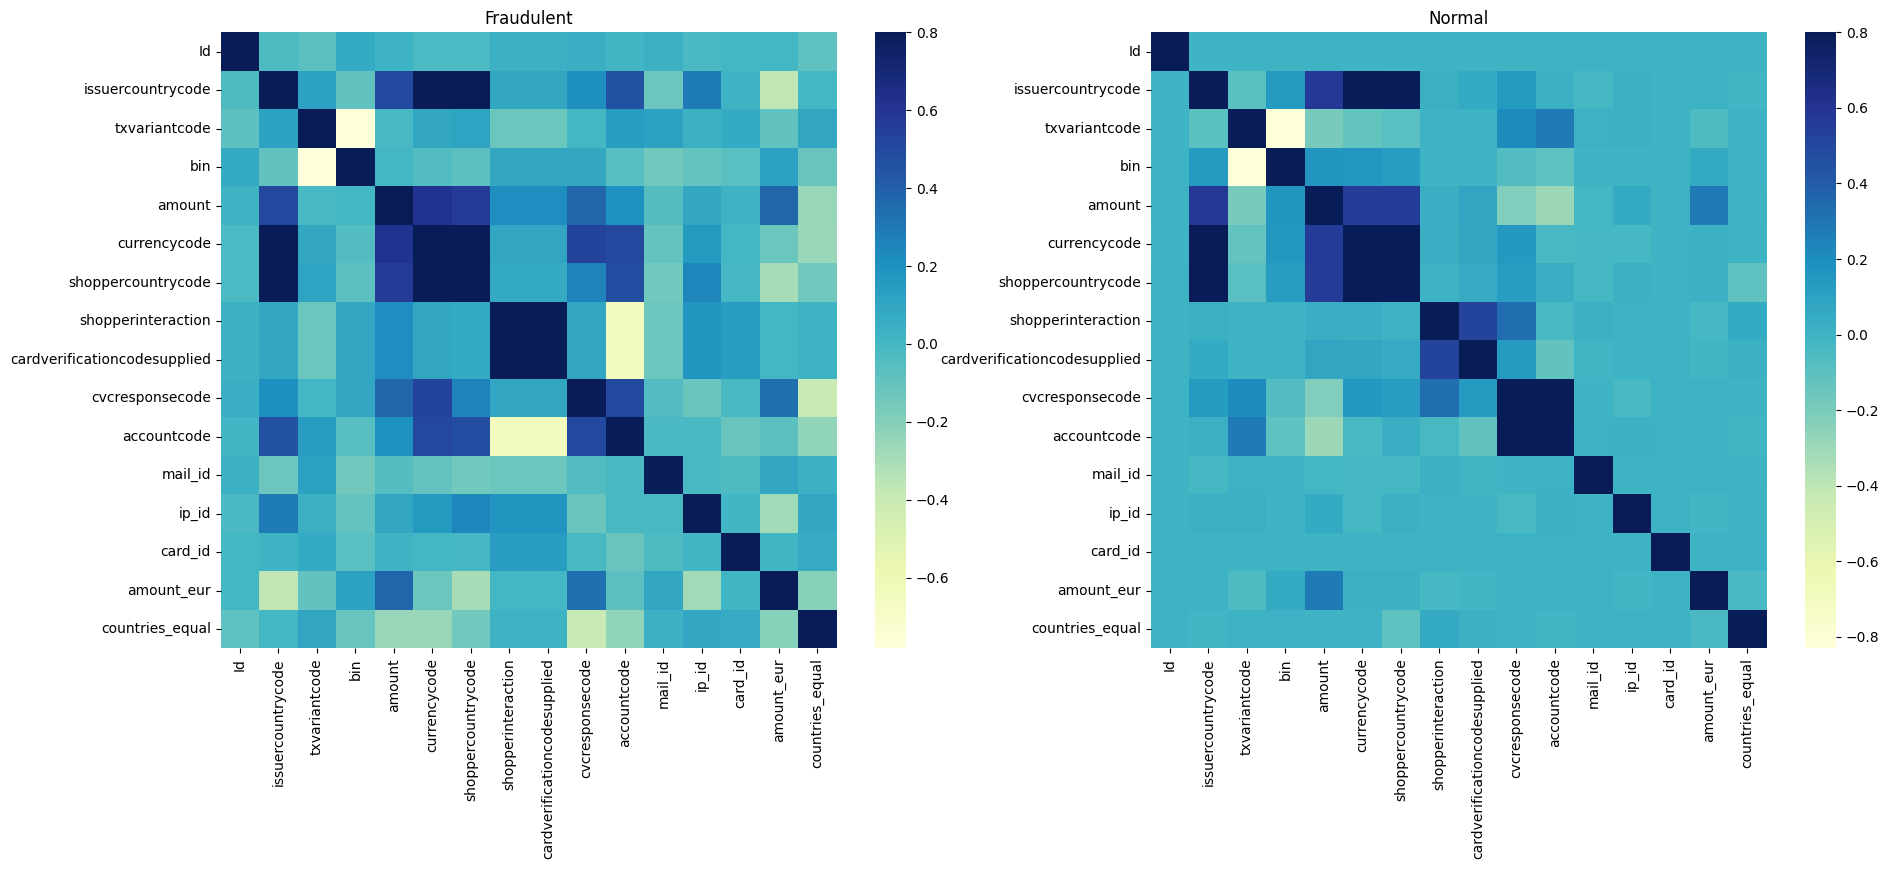

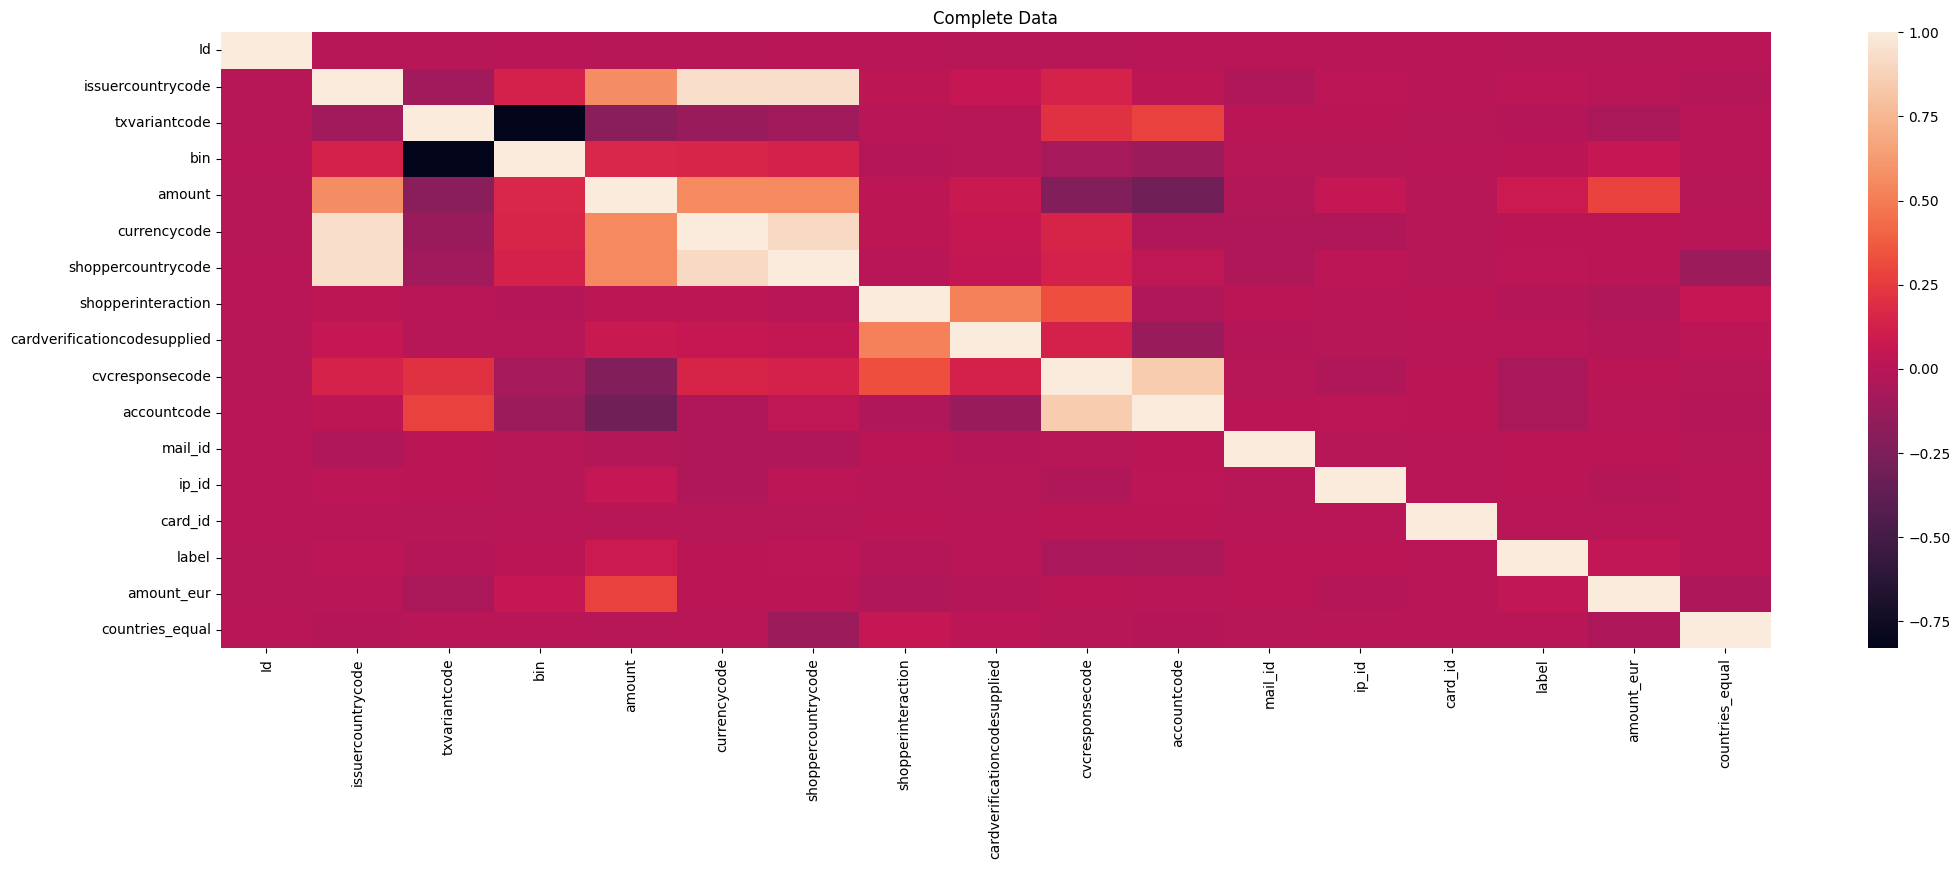

In [8]:
# Basic plot, heatmaps of the correlation matrices
# Adjusted from W1_Visuals.ipynb

#correlation matrices
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(df.query('label==1').drop(['label', 'accountcode_cc'], axis=1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraudulent')

sns.heatmap(df.query('label==0').drop(['label', 'accountcode_cc'], axis=1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu')
ax2.set_title('Normal')

plt.show()

f, (ax1) = plt.subplots(1,figsize =(25, 8))
sns.heatmap(df.drop(['accountcode_cc'], axis=1).corr())
ax1.set_title('Complete Data')
plt.show()

### 1a. Plot visulations 

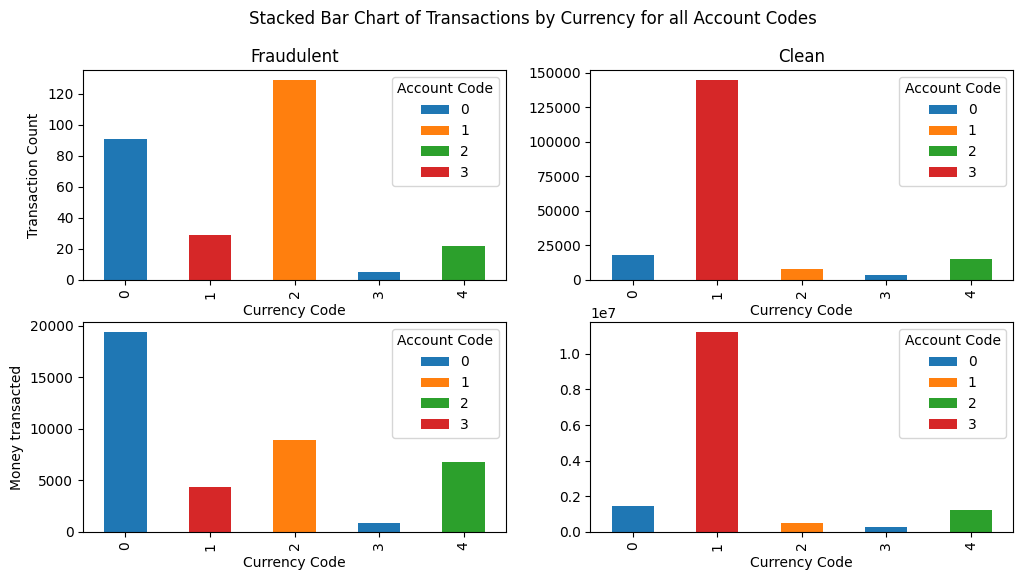

In [9]:
# Plot 1: Distribution of transactions by account code

# Create a contingency table
table_all = pd.crosstab(df['currencycode'], df['accountcode'])
table_fraudulent = pd.crosstab(fraudulent_df['currencycode'], fraudulent_df['accountcode'])
table_normal = pd.crosstab(normal_df['currencycode'], normal_df['accountcode'])
table_fraudulent_amount = pd.crosstab(fraudulent_df['currencycode'], fraudulent_df['accountcode'], values=df['amount_eur'], aggfunc='sum')
table_normal_amount = pd.crosstab(normal_df['currencycode'], normal_df['accountcode'], values=df['amount_eur'], aggfunc='sum')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))  # Create a figure and a 1x2 subplot grid
fig.suptitle('Stacked Bar Chart of Transactions by Currency for all Account Codes')

# Plot a stacked bar chart
table_fraudulent.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Fraudulent')
ax1.set_xlabel('Currency Code')
ax1.set_ylabel('Transaction Count')
ax1.legend(title='Account Code')


table_normal.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Clean')
ax2.set_xlabel('Currency Code')
# ax2.set_ylabel('Transaction Count')
ax2.legend(title='Account Code')

table_fraudulent_amount.plot(kind='bar', stacked=True, ax=ax3)
ax3.set_xlabel('Currency Code')
ax3.set_ylabel('Money transacted')
ax3.legend(title='Account Code')


table_normal_amount.plot(kind='bar', stacked=True, ax=ax4)
ax4.set_xlabel('Currency Code')
ax4.legend(title='Account Code')

plt.show()

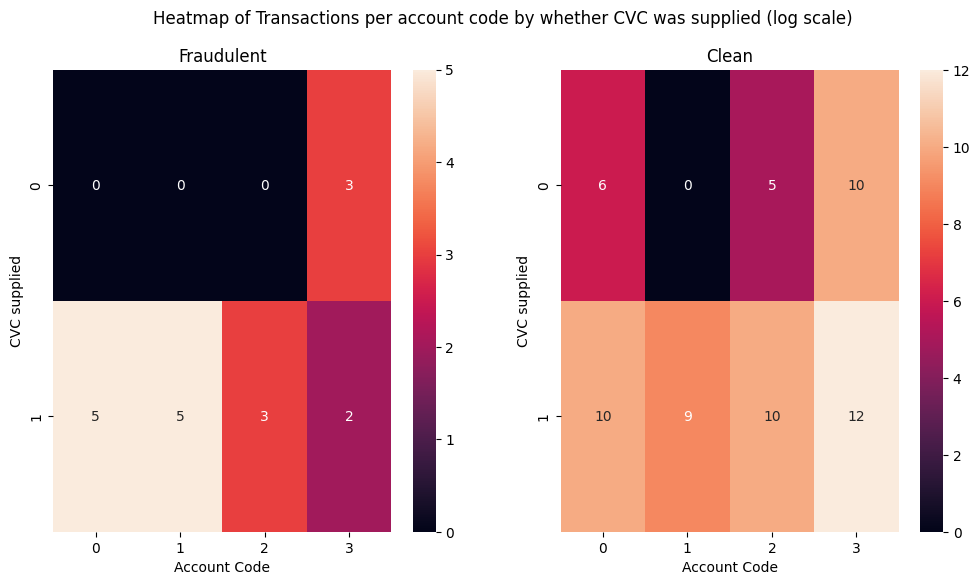

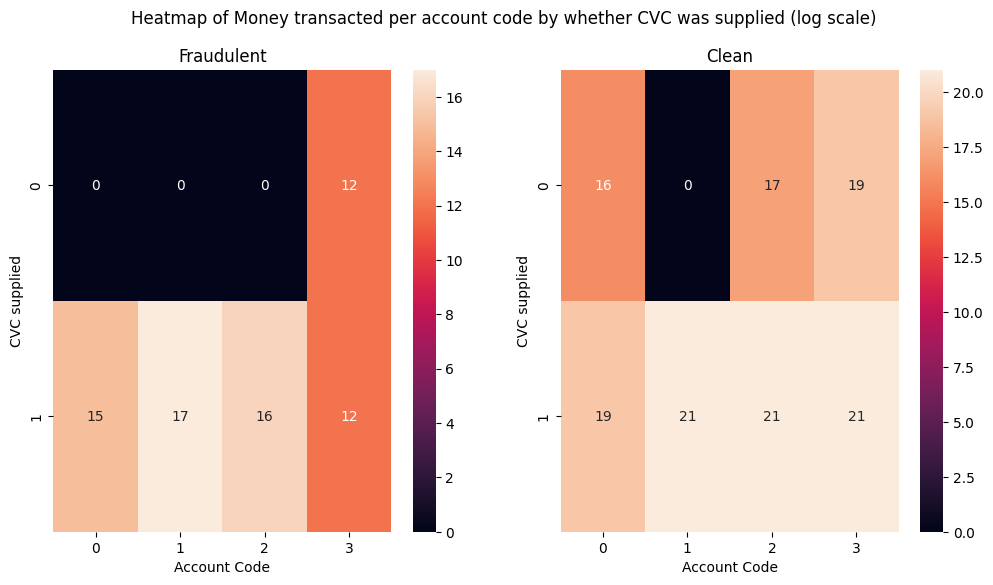

In [20]:
# Plot 2: Heatmap of transactions and amounts transacted, per account code, by whether CVC was supplied
# using log scale

table_all = pd.crosstab(df['cardverificationcodesupplied'], df['accountcode'])
table_fraudulent = pd.crosstab(fraudulent_df['cardverificationcodesupplied'], fraudulent_df['accountcode']).map(lambda x: np.log(x + 1)).map(round)
table_normal = pd.crosstab(normal_df['cardverificationcodesupplied'], normal_df['accountcode']).map(lambda x: np.log(x + 1)).map(round)
table_fraudulent_amount = pd.crosstab(fraudulent_df['cardverificationcodesupplied'], fraudulent_df['accountcode'], values=df['amount'], aggfunc='sum').fillna(1).map(np.log).map(round)
table_normal_amount = pd.crosstab(normal_df['cardverificationcodesupplied'], normal_df['accountcode'], values=df['amount'], aggfunc='sum').fillna(1).map(np.log).map(round)

# sns.heatmap(table_all, annot=True, fmt='d')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Create a figure and a 1x2 subplot grid
fig.suptitle('Heatmap of Transactions per account code by whether CVC was supplied (log scale)')

# Plot a stacked bar chart
sns.heatmap(table_fraudulent, annot=True, fmt='d', ax=ax1)
ax1.set_title('Fraudulent')
ax1.set_xlabel('Account Code')
ax1.set_ylabel('CVC supplied')

sns.heatmap(table_normal, annot=True, fmt='d', ax=ax2)
ax2.set_xlabel('Account Code')
ax2.set_ylabel('CVC supplied')
ax2.set_title('Clean')



fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Create a figure and a 1x2 subplot grid
fig2.suptitle('Heatmap of Money transacted per account code by whether CVC was supplied (log scale)')


sns.heatmap(table_fraudulent_amount, annot=True, fmt='g', ax=ax3)
ax3.set_title('Fraudulent')
ax3.set_xlabel('Account Code')
ax3.set_ylabel('CVC supplied')


sns.heatmap(table_normal_amount, annot=True, fmt='g', ax=ax4)
ax4.set_title('Clean')
ax4.set_xlabel('Account Code')
ax4.set_ylabel('CVC supplied')

plt.show()

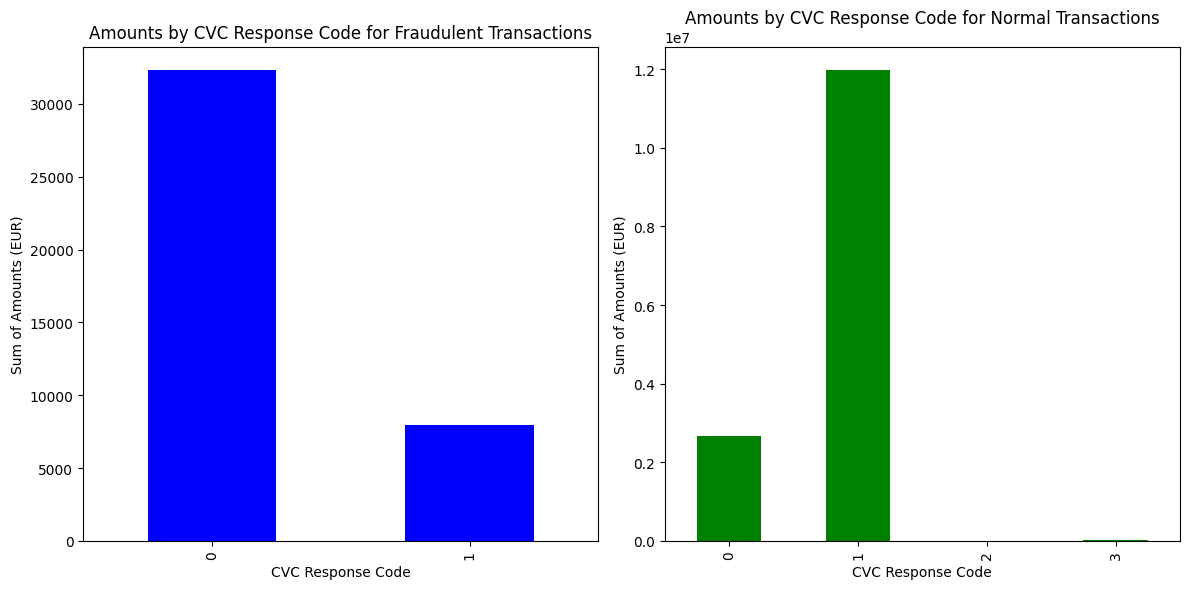

In [19]:
# Plot 3: Amounts of money transacted by whether cvc was supplied

# Correlation between amount of euros transacted and the cvc response code
sum_fraudulent = fraudulent_df.groupby('cvcresponsecode')['amount_eur'].sum()
sum_normal = normal_df.groupby('cvcresponsecode')['amount_eur'].sum()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the bar chart for the first DataFrame
sum_fraudulent.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title('Amounts by CVC Response Code for Fraudulent Transactions')
ax[0].set_xlabel('CVC Response Code')
ax[0].set_ylabel('Sum of Amounts (EUR)')

# Plot the bar chart for the second DataFrame
sum_normal.plot(kind='bar', ax=ax[1], color='green')
ax[1].set_title('Amounts by CVC Response Code for Normal Transactions')
ax[1].set_xlabel('CVC Response Code')
ax[1].set_ylabel('Sum of Amounts (EUR)')

plt.tight_layout()
plt.show()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

#### Plot 1: Stacked bar chart of transactions by currency for all account codes
In this plot we show how many transactions as well as the total circulation of money from each currency to each account code. Firstly, it seems that all accounts deal strictly in local currency. We compare the transactions for fraudulent and normal cases, and see little difference when looking at transactions and total circulation, except for the case of fraudulent mexican transactions. Fraud is more common in mexican and australian accounts compared to normal transactions being dominated by the Brits.

#### Plot 2: Heatmap of transactions and monetary circulation per account code by whether CVC was supplied (log scale)
This plot shows us that fraudulent transactions are less often CVC verified.

#### Plot 3: Bar chart of CVC response code types by amount of money circulated
This plot shows us that fraudulent transactions more often have a code 0 (3x more than code 1), but for normal transactions it is 4x more common to have code 1 over 0.

## 4. Classification task – 2 A4

### Additional Data Preprocessing

In [10]:
# check dataframe
df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1


In [11]:
"""
1. Scale numeric features using StandardScaler
"""

scaler = MinMaxScaler()
df[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id']] = scaler.fit_transform(df[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id']])

In [12]:
X = df.drop(['label', 'accountcode_cc'], axis=1)
y = df['label']

### 10-Fold Cross-Validation Split - Oversampling

In [43]:
# use Stratified K-Folds cross-validation to split the data into 10 folds
skf = StratifiedKFold(n_splits=10)

train_folds = []
test_folds = []

# keep train and test data for each fold, as using Startified K-Folder
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}: Train: {len(train_index)}, Test: {len(test_index)}")
    train_folds.append((X.iloc[train_index], y.iloc[train_index]))
    test_folds.append((X.iloc[test_index], y.iloc[test_index]))

Fold 1: Train: 170665, Test: 18963
Fold 2: Train: 170665, Test: 18963
Fold 3: Train: 170665, Test: 18963
Fold 4: Train: 170665, Test: 18963
Fold 5: Train: 170665, Test: 18963
Fold 6: Train: 170665, Test: 18963
Fold 7: Train: 170665, Test: 18963
Fold 8: Train: 170665, Test: 18963
Fold 9: Train: 170666, Test: 18962
Fold 10: Train: 170666, Test: 18962


In [44]:
# perform oversampling on the training data
for i, (X_train, y_train) in enumerate(train_folds):
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    train_folds[i] = (X_resampled, y_resampled)

In [45]:
# function to evaluate models for K-folds
def evaluate_model_k_folds(model, train_folds, test_folds):
    # calculate accuracy and probabilities of fraudulent transactions
    # for each fold
    accuracies = []
    probs = []

    for i, (X_train, y_train) in enumerate(train_folds):
        # create new model instance
        if model=='rf':
            clf = RandomForestClassifier(random_state=42)
        elif model=='svm':
            clf = SVC(probability=True, random_state=42)

        # fit the model
        X_test, y_test = test_folds[i]
        clf.fit(X_train, y_train)

        # predict and calculate accuracy
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"Fold {i+1} Accuracy: {accuracy:.5f}")

        # calculate probabilities of fraudulent transactions for ROC curve
        y_probs = clf.predict_proba(X_test)[:, 1]
        probs.append(y_probs)

    return accuracies, probs

In [46]:
def plot_roc_curve(y_probs, y_test):
    """
    Plot the ROC curve for the given test labels and predicted labels
    
    Parameters:
    y_probs: list of probabilities of fraudulent transactions
    y_test: test labels
    """
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))

    auc_scores = []

    for i in range(len(y_probs)):
        # Compute the ROC curve and AUC score
        fpr, tpr, _ = roc_curve(y_test[i], y_probs[i])
        auc_scores.append(auc(fpr, tpr))

        plt.plot(fpr, tpr)

    print(f"Mean AUC: {np.mean(auc_scores):.5f}")

    # plotting details
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curves for 10-Folds")
    plt.grid()
    plt.show()

### Black-Box Model: Random Forest

In [47]:
# Evaluate the model using K-Folds
rf_accuracies, rf_probs = evaluate_model_k_folds('rf', train_folds, test_folds)

Fold 1 Accuracy: 0.85725
Fold 2 Accuracy: 0.86300
Fold 3 Accuracy: 0.86410
Fold 4 Accuracy: 0.88773
Fold 5 Accuracy: 0.87075
Fold 6 Accuracy: 0.87560
Fold 7 Accuracy: 0.86547
Fold 8 Accuracy: 0.87423
Fold 9 Accuracy: 0.86647
Fold 10 Accuracy: 0.86647


Mean AUC: 0.94858


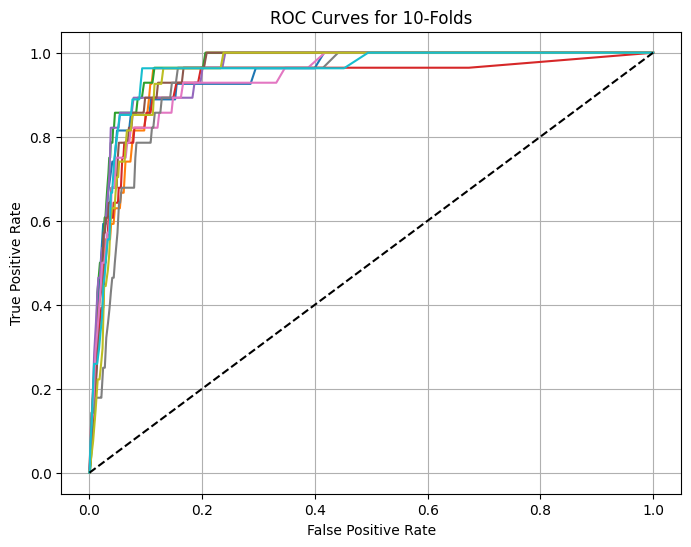

In [48]:
plot_roc_curve(rf_probs, [y_test for _, y_test in test_folds])

### White-Box Model: SVM

In [18]:
# Evaluate the model using K-Folds
svm_accuracies, svm_probs = evaluate_model_k_folds('svm', train_folds, test_folds)

Fold 1 Accuracy: 0.00142
Fold 2 Accuracy: 0.75036
Fold 3 Accuracy: 0.00148


KeyboardInterrupt: 

Mean AUC: 0.45846


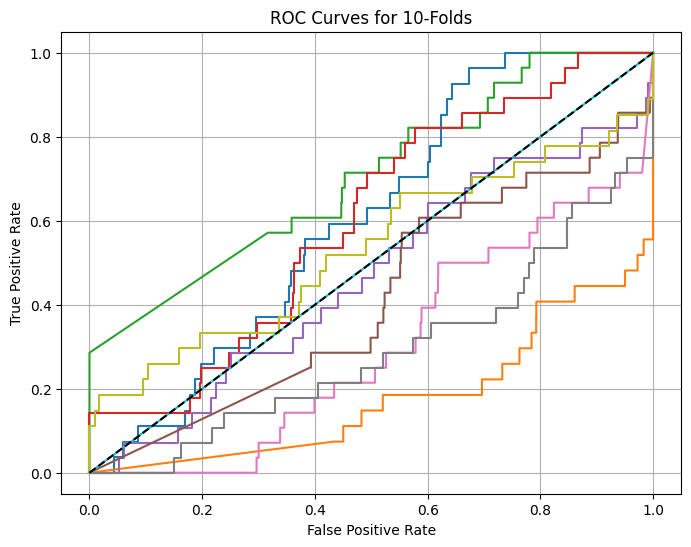

In [17]:
plot_roc_curve(svm_probs, [y_test for _, y_test in test_folds])

### 4a. Print relevant plots and metrics with clear headings.

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below

In [49]:
# read the train data
df = pd.read_csv(train_path)
df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


In [50]:
# Prepare card id and ip id for plotting
# Preprocessing pipeline adjusted from W1_Visuals.ipynb

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df['card_id'])
df['card_id'] = card_enc.transform(df.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df['ip_id'])
df['ip_id'] = ip_enc.transform(df.ip_id)

#Encoding, Cleaning the data
df.loc[df['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df.loc[df['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df.loc[df['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df['issuercountrycode'].unique()
unique_shopper_cc = df['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df['issuercountrycode'] = enc.transform(df.issuercountrycode)
df['shoppercountrycode'] = enc.transform(df.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df['txvariantcode'])
df['txvariantcode'] = enc1.transform(df.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df['currencycode'])
df['currencycode'] = enc2.transform(df.currencycode)

enc3 = LabelEncoder()
enc3.fit(df['shopperinteraction'])
df['shopperinteraction'] = enc3.transform(df.shopperinteraction)

df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account','',x))
df['accountcode_cc'] = 0
df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df.loc[(df['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df.loc[(df['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df.loc[(df['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df['accountcode'])
df['accountcode'] = enc4.transform(df.accountcode)

### Better to use one-hot encoding, very few categories
enc5 = LabelEncoder()
enc5.fit(df['cardverificationcodesupplied'])
df['cardverificationcodesupplied'] = enc5.transform(df.cardverificationcodesupplied)

df.loc[df['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df['mail_id'])
df['mail_id'] = enc6.transform(df.mail_id)

df.loc[df['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
df.loc[df['countries_equal'] == False,'countries_equal'] = 0
df.loc[df['countries_equal'] == True,'countries_equal'] = 1

C:\Users\Thanos\AppData\Local\Temp\ipykernel_14760\929892654.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'GB' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
C:\Users\Thanos\AppData\Local\Temp\ipykernel_14760\929892654.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['countries_equal'] == False,'countries_equal'] = 0


In [59]:
# We will do scaling just before the evaluation part -
# while we construct new features, we keep the values as they are

# create a copy of df, to use for feature engineering
df_bonus = df.copy()
df_bonus.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1


##### Extracting aggregate features

In [60]:
def aggregate_features(df_bonus):
    # FEATURE 1: Number of transactions per card

    # compute number of times each card is used 
    card_use = df_bonus.groupby('card_id').size()
    df_bonus['card_frequency'] = df_bonus['card_id'].map(card_use)

    # FEATURE 2: Total amount spent by each card

    # compute total amount spent by each card
    card_amount = df_bonus.groupby('card_id')['amount_eur'].sum()
    df_bonus['card_total_amount'] = df_bonus['card_id'].map(card_amount)

    # FEATURE 3: Number of transactions per IP address

    # compute number of times each IP address is used
    ip_use = df_bonus.groupby('ip_id').size()
    df_bonus['ip_frequency'] = df_bonus['ip_id'].map(ip_use)

    # FEATURE 4: Number of transactions per mail address

    # compute number of times each mail address is used
    ip_use = df_bonus.groupby('mail_id').size()
    df_bonus['mail_frequency'] = df_bonus['mail_id'].map(ip_use)

    # FEATURE 5: Combine 'cardverificationcodesupplied' and 'cvcresponsecode' columns
    # to create a new feature

    # assign a different value to eac combination of the two features
    df_bonus['cvc_outcome'] = 1
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['cvcresponsecode'].isin([0, 3]))), 'cvc_outcome'] = 1
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['cvcresponsecode'] == 1)), 'cvc_outcome'] = 2
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['cvcresponsecode'] == 2)), 'cvc_outcome'] = 3
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['cvcresponsecode'].isin([0, 3]))), 'cvc_outcome'] = 4
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['cvcresponsecode'] == 1)), 'cvc_outcome'] = 5
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['cvcresponsecode'] == 2)), 'cvc_outcome'] = 6

    # FEATURE 6: Combine 'cardverificationcodesupplied' and 'currencycode'
    # after the visual results of our second plot from Part 1

    # assign a different value to each combination of the two features
    df_bonus['cvc_and_currency'] = 1
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['currencycode'] == 0)), 'cvc_and_currency'] = 1
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['currencycode'] == 1)), 'cvc_and_currency'] = 2
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['currencycode'] == 2)), 'cvc_and_currency'] = 3
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 0) & (df_bonus['currencycode'] == 3)), 'cvc_and_currency'] = 4
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['currencycode'] == 0)), 'cvc_and_currency'] = 5
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['currencycode'] == 1)), 'cvc_and_currency'] = 6
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['currencycode'] == 2)), 'cvc_and_currency'] = 7
    df_bonus.loc[((df_bonus['cardverificationcodesupplied'] == 1) & (df_bonus['currencycode'] == 3)), 'cvc_and_currency'] = 8

    # FEATURE 7: Combine 'shopperinteraction' and 'txvariantcode' columns
    # to create a new feature, for the combination of type of interaction and card

    # assign a different value to each combination of the two features
    df_bonus['interaction_and_card'] = 1
    for i in range(3):
        for j in range(13):
            df_bonus.loc[((df_bonus['txvariantcode'] == j) & (df_bonus['shopperinteraction'] == i)), 'interaction_and_card'] = i*13 + j + 1

    # FEATURE 8: Total amount spent in transactions with this shopper country code

    # compute total amount spent by each card
    shopper_country_amount = df_bonus.groupby('shoppercountrycode')['amount_eur'].sum()
    df_bonus['shopper_country_total_amount'] = df_bonus['shoppercountrycode'].map(shopper_country_amount)

    return df_bonus


df_bonus = aggregate_features(df_bonus)

# check new feature
df_bonus.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,accountcode_cc,countries_equal,card_frequency,card_total_amount,ip_frequency,mail_frequency,cvc_outcome,cvc_and_currency,interaction_and_card,shopper_country_total_amount
0,1,49,2,546097.0,4500.0,1,49,1,1,1,...,GB,1,1,52.175123,3,1,5,6,16,1.075376e+07
1,2,49,3,557349.0,3395.0,1,49,1,1,1,...,GB,1,1,39.363232,1,1,5,6,17,1.075376e+07
2,3,49,2,542011.0,3895.0,1,49,1,1,1,...,GB,1,1,45.160467,1,1,5,6,16,1.075376e+07
3,4,49,8,465943.0,15345.0,1,49,0,0,0,...,GB,1,3,206.207680,3,3,1,2,9,1.075376e+07
4,6,49,8,475127.0,5095.0,1,49,1,1,1,...,GB,1,1,59.073834,1,1,5,6,22,1.075376e+07


In [53]:
# Scaling features with MinMaxScaler

scaler = MinMaxScaler()
df_bonus[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id', 'card_frequency', 'card_total_amount', 
          'ip_frequency', 'mail_frequency', 'shopper_country_total_amount']] = scaler.fit_transform(df_bonus[['bin', 
                    'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id', 'card_frequency', 'card_total_amount', 
          'ip_frequency', 'mail_frequency', 'shopper_country_total_amount']])

df_bonus.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,accountcode_cc,countries_equal,card_frequency,card_total_amount,ip_frequency,mail_frequency,cvc_outcome,cvc_and_currency,interaction_and_card,shopper_country_total_amount
0,1,49,2,0.915256,0.002275,1,49,1,1,1,...,GB,1,0.000000,0.007208,0.005435,0.000000,5,6,16,1.0
1,2,49,3,0.985768,0.001710,1,49,1,1,1,...,GB,1,0.000000,0.005428,0.000000,0.000000,5,6,17,1.0
2,3,49,2,0.889650,0.001966,1,49,1,1,1,...,GB,1,0.000000,0.006233,0.000000,0.000000,5,6,16,1.0
3,4,49,8,0.412956,0.007821,1,49,0,0,0,...,GB,1,0.022472,0.028618,0.005435,0.007299,1,2,9,1.0
4,6,49,8,0.470509,0.002580,1,49,1,1,1,...,GB,1,0.000000,0.008167,0.000000,0.000000,5,6,22,1.0


##### Evaluating each aggregate feature

In [55]:
# We are using a Random Forest Classifier, as it was the best model from our experiments

# original features used for classification
existing_features = df.columns.tolist()
existing_features.remove('label')
existing_features.remove('accountcode_cc')

# new aggregate features
new_features = df_bonus.columns.tolist()
for f in existing_features:
    new_features.remove(f)
new_features.remove('label')
new_features.remove('accountcode_cc')

print('New features are: ', new_features)

# we are going to add each of the new features independently to the original features
# and evaluate performance of classifier with the new feature
for new_f in new_features:
    cols = existing_features.copy()
    cols.append(new_f)
    X = df_bonus[cols]
    y = df_bonus['label']

    # use Stratified K-Folds cross-validation to split the data into 10 folds
    skf = StratifiedKFold(n_splits=10)

    train_folds = []
    test_folds = []

    # keep train and test data for each fold, as using Startified K-Folder
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Fold {i+1}: Train: {len(train_index)}, Test: {len(test_index)}")
        train_folds.append((X.iloc[train_index], y.iloc[train_index]))
        test_folds.append((X.iloc[test_index], y.iloc[test_index]))

    # perform oversampling on the training data
    for i, (X_train, y_train) in enumerate(train_folds):
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        train_folds[i] = (X_resampled, y_resampled)

    auc_scores = []

    # iterate for each cross-validation fold
    for i, (X_train, y_train) in enumerate(train_folds):
        
        clf = RandomForestClassifier(random_state=42)

        # fit the model
        X_test, y_test = test_folds[i]
        clf.fit(X_train, y_train)

        # calculate probabilities of fraudulent transactions for AUC score
        y_probs = clf.predict_proba(X_test)[:, 1]

        
        # Compute the ROC curve and AUC score
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc_scores.append(auc(fpr, tpr))

    print("Added feature: ", new_f)
    print(f"Mean AUC: {np.mean(auc_scores):.5f}")

    
    

New features are:  ['card_frequency', 'card_total_amount', 'ip_frequency', 'mail_frequency', 'cvc_outcome', 'cvc_and_currency', 'interaction_and_card', 'shopper_country_total_amount']
Fold 1: Train: 170665, Test: 18963
Fold 2: Train: 170665, Test: 18963
Fold 3: Train: 170665, Test: 18963
Fold 4: Train: 170665, Test: 18963
Fold 5: Train: 170665, Test: 18963
Fold 6: Train: 170665, Test: 18963
Fold 7: Train: 170665, Test: 18963
Fold 8: Train: 170665, Test: 18963
Fold 9: Train: 170666, Test: 18962
Fold 10: Train: 170666, Test: 18962
Added feature:  card_frequency
Mean AUC: 0.95091
Fold 1: Train: 170665, Test: 18963
Fold 2: Train: 170665, Test: 18963
Fold 3: Train: 170665, Test: 18963
Fold 4: Train: 170665, Test: 18963
Fold 5: Train: 170665, Test: 18963
Fold 6: Train: 170665, Test: 18963
Fold 7: Train: 170665, Test: 18963
Fold 8: Train: 170665, Test: 18963
Fold 9: Train: 170666, Test: 18962
Fold 10: Train: 170666, Test: 18962
Added feature:  card_total_amount
Mean AUC: 0.95107
Fold 1: Train

## Kaggle Competition

In [61]:
# preprocess test data
df_test = pd.read_csv(test_path)

#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df_test['card_id'])
df_test['card_id'] = card_enc.transform(df_test.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df_test['ip_id'])
df_test['ip_id'] = ip_enc.transform(df_test.ip_id)

#Encoding, Cleaning the data
df_test.loc[df_test['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df_test.loc[df_test['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df_test.loc[df_test['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df_test['issuercountrycode'].unique()
unique_shopper_cc = df_test['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df_test['issuercountrycode'] = enc.transform(df_test.issuercountrycode)
df_test['shoppercountrycode'] = enc.transform(df_test.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df_test['amount_eur'] = df_test.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df_test['txvariantcode'])
df_test['txvariantcode'] = enc1.transform(df_test.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df_test['currencycode'])
df_test['currencycode'] = enc2.transform(df_test.currencycode)

enc3 = LabelEncoder()
enc3.fit(df_test['shopperinteraction'])
df_test['shopperinteraction'] = enc3.transform(df_test.shopperinteraction)

df_test['accountcode'] = df_test['accountcode'].apply(lambda x: re.sub('Account','',x))
df_test['accountcode_cc'] = 0
df_test.loc[(df_test['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df_test.loc[(df_test['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df_test.loc[(df_test['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df_test.loc[(df_test['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df_test['accountcode'])
df_test['accountcode'] = enc4.transform(df_test.accountcode)

### Better to use one-hot encoding, very few categories
enc5 = LabelEncoder()
enc5.fit(df_test['cardverificationcodesupplied'])
df_test['cardverificationcodesupplied'] = enc5.transform(df_test.cardverificationcodesupplied)

df_test.loc[df_test['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df_test['mail_id'])
df_test['mail_id'] = enc6.transform(df_test.mail_id)

df_test.loc[df_test['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df_test['countries_equal'] = (df_test['shoppercountrycode'] == df_test['issuercountrycode'])
df_test.loc[df_test['countries_equal'] == False,'countries_equal'] = 0
df_test.loc[df_test['countries_equal'] == True,'countries_equal'] = 1

C:\Users\Thanos\AppData\Local\Temp\ipykernel_14760\2861964316.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'GB' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[(df_test['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
C:\Users\Thanos\AppData\Local\Temp\ipykernel_14760\2861964316.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['countries_equal'] == False,'countries_equal'] = 0


In [62]:
df_test = aggregate_features(df_test)

# Scaling features with MinMaxScaler

scaler = MinMaxScaler()
df_test[['bin', 'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id', 'card_frequency', 'card_total_amount', 
          'ip_frequency', 'mail_frequency', 'shopper_country_total_amount']] = scaler.fit_transform(df_test[['bin', 
                    'amount', 'amount_eur', 'mail_id', 'ip_id', 'card_id', 'card_frequency', 'card_total_amount', 
          'ip_frequency', 'mail_frequency', 'shopper_country_total_amount']])

df_test.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,accountcode_cc,countries_equal,card_frequency,card_total_amount,ip_frequency,mail_frequency,cvc_outcome,cvc_and_currency,interaction_and_card,shopper_country_total_amount
0,0,37,7,0.577445,0.000793,1,37,1,0,1,...,GB,1,0.0,0.004321,0.0,0.0,2,2,21,1.000000
1,5,37,2,0.985958,0.004225,1,37,1,1,1,...,GB,1,0.0,0.022196,0.0,0.0,5,6,16,1.000000
2,7,37,9,0.582031,0.013879,1,37,1,1,1,...,GB,1,0.0,0.072477,0.0,0.0,5,6,23,1.000000
3,9,83,7,0.590784,0.011878,3,83,1,1,0,...,APAC,1,0.0,0.031739,0.0,0.0,4,8,21,0.027889
4,16,5,1,0.744658,0.008729,0,5,1,1,0,...,APAC,1,0.0,0.024645,0.0,0.0,4,5,15,0.132813


In [69]:
# create new model instance
clf = RandomForestClassifier(random_state=42)

X = df_bonus[existing_features+['card_frequency', 'card_total_amount', 'ip_frequency']]
y = df_bonus['label']

# resample training data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# fit on all training data
clf.fit(X_resampled, y_resampled)

X_test = df_test[existing_features+['card_frequency', 'card_total_amount', 'ip_frequency']]

# calculate probabilities of fraudulent transactions for ROC curve
y_probs = clf.predict_proba(X_test)[:, 1]

In [70]:
# save to csv - ID and y_probs
df_test['Predicted'] = y_probs
df_test[['Id', 'Predicted']].to_csv('test_predictions.csv', index=False)